In [1]:
!pip install modal-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [3]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling, classifier_uncertainty
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# **make cifar-10 imbalanced**

In [4]:
import numpy as np
from tensorflow.keras.datasets import mnist, cifar10

def remove_samples(dataset, labels, classes_to_remove, num_samples):
    filtered_indices = []
    for class_label in classes_to_remove:
        class_indices = np.where(labels == class_label)[0]
        num_samples_to_remove = min(len(class_indices), num_samples)
        removed_indices = np.random.choice(class_indices, size=num_samples_to_remove, replace=False)
        filtered_indices.extend(removed_indices)

    filtered_data = np.delete(dataset, filtered_indices, axis=0)
    filtered_labels = np.delete(labels, filtered_indices, axis=0)
    return filtered_data, filtered_labels

# Load the MNIST dataset
(train_images, train_labels), (X_test, y_test) = cifar10.load_data()

# Define the classes to remove samples from and the number of samples to remove
classes_to_remove = [0, 1, 2, 3, 4, 5]
num_samples_to_remove = 4000

# Remove samples from specified classes
X_train, y_train = remove_samples(train_images, train_labels, classes_to_remove, num_samples_to_remove)

# Check the shape of the filtered dataset
print("Filtered Train Images Shape:", X_train.shape)
print("Filtered Train Labels Shape:", y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Filtered Train Images Shape: (26000, 32, 32, 3)
Filtered Train Labels Shape: (26000, 1)


In [5]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Print the number of samples in each class
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 5000 samples
Class 7: 5000 samples
Class 8: 5000 samples
Class 9: 5000 samples


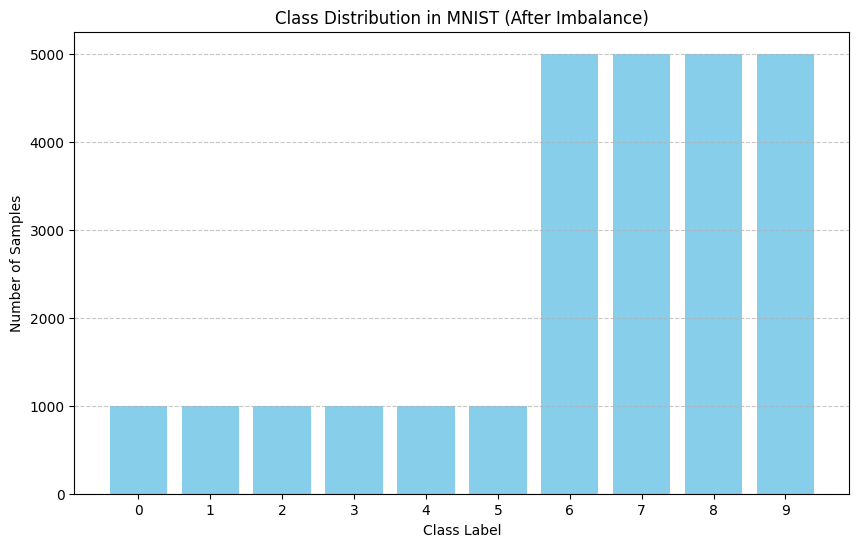

In [6]:
import matplotlib.pyplot as plt

unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST (After Imbalance)')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
len(X_train)

26000

CNN model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

def create_model():
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten the output for the fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    return model

In [10]:
# Use predict instead of predict_proba
def predict_proba(self, X, **predict_proba_kwargs):
    return self.estimator.predict(X, **predict_proba_kwargs)
ActiveLearner.predict_proba = predict_proba

# ***Random Sampling:***

prepare data

In [11]:
#labeled data
initial_idx = slice(400)
X_initial_1 = X_train[initial_idx]
y_initial_1 = y_train[initial_idx]


#unlabeled data
X_pool_1 = np.delete(X_train, initial_idx, axis=0)
y_pool_1 = np.delete(y_train, initial_idx, axis=0)

pool_indices = np.arange(len(X_pool_1))

In [12]:
def random_sampling(classifier, X_pool_1):
    n_samples = len(X_pool_1)
    query_indices = np.random.choice(range(n_samples), size=1000, replace=False)
    return query_indices, X_pool_1[query_indices]

In [13]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = random_sampling,
    X_training=X_initial_1,
    y_training=y_initial_1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2652 - loss: 3.2697


44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.4550 - loss: 2.2876
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
22/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5808 - loss: 1.5530

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5697 - loss: 1.5670
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5875 - loss: 1.3911
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6552 - loss: 1.1600
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6842 - loss: 0.9547
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7193 - loss: 0.8978
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - loss: 0.7449
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7790 - loss: 0.6741
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8113 - loss: 0.5924
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4

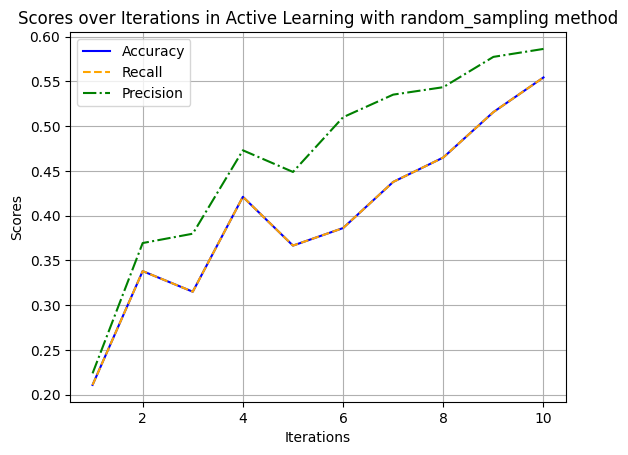

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = []
recalls  = []
precisions = []
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_1)
    X_query, y_query = X_pool_1[query_idx], y_pool_1[query_idx]


    learner.teach(X=X_query, y=y_query)

    X_pool_1 = np.delete(X_pool_1, query_idx, axis=0)
    y_pool_1 = np.delete(y_pool_1, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)

    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")

plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with random_sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [15]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5543


In [16]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.5861534556678383
Recall: 0.5543
F1-score: 0.5304521103817846


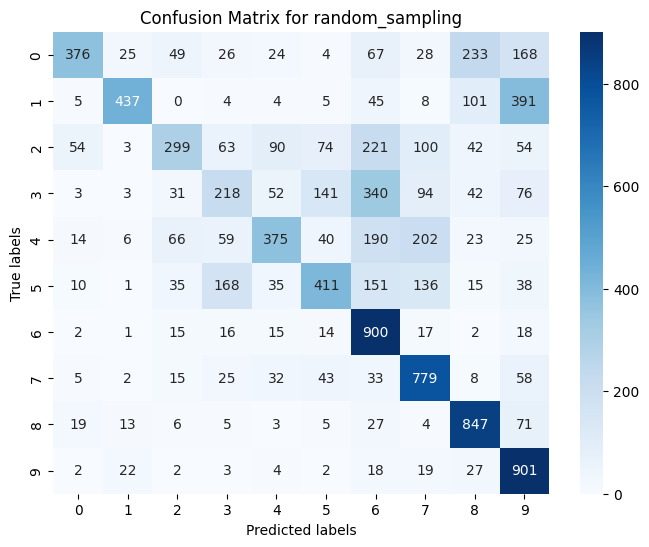

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for random_sampling')
plt.show()

# ***margin_sampling:***

prepare data

In [18]:
#labeled data
initial_idx = slice(400)
X_initial_2 = X_train[initial_idx]
y_initial_2 = y_train[initial_idx]


#unlabeled data
X_pool_2 = np.delete(X_train, initial_idx, axis=0)
y_pool_2 = np.delete(y_train, initial_idx, axis=0)

In [19]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = margin_sampling,
    X_training=X_initial_2,
    y_training=y_initial_2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.2148 - loss: 3.3310


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 563ms/step - accuracy: 0.5990 - loss: 1.3764
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 599ms/step - accuracy: 0.7667 - loss: 0.7500
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 546ms/step - accuracy: 0.8359 - loss: 0.4541
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.8951 - loss: 0.3424
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - accuracy: 0.9018 - loss: 0.2603
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 623ms/step - accuracy: 0.9418 - loss: 0.1749
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 614ms/step - accuracy: 0.9573 - loss: 0.1514
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13

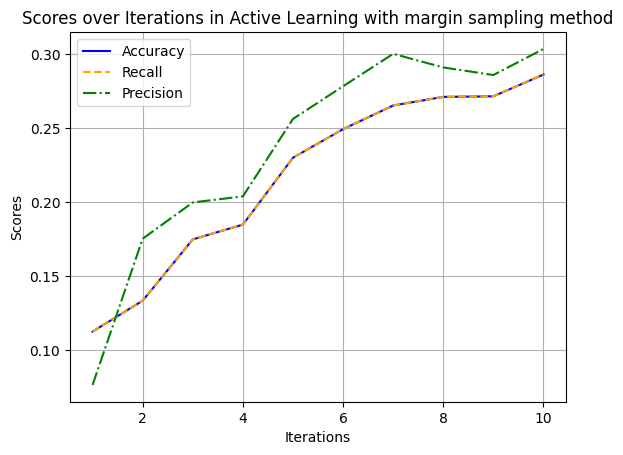

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = []
recalls  = []
precisions = []
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_2)
    X_query, y_query = X_pool_2[query_idx], y_pool_2[query_idx]


    learner.teach(X=X_query, y=y_query)

    X_pool_2 = np.delete(X_pool_2, query_idx, axis=0)
    y_pool_2 = np.delete(y_pool_2, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)

    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")

plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with margin sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [21]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.2863


In [22]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.30361807165738475
Recall: 0.2863
F1-score: 0.20461639565905393


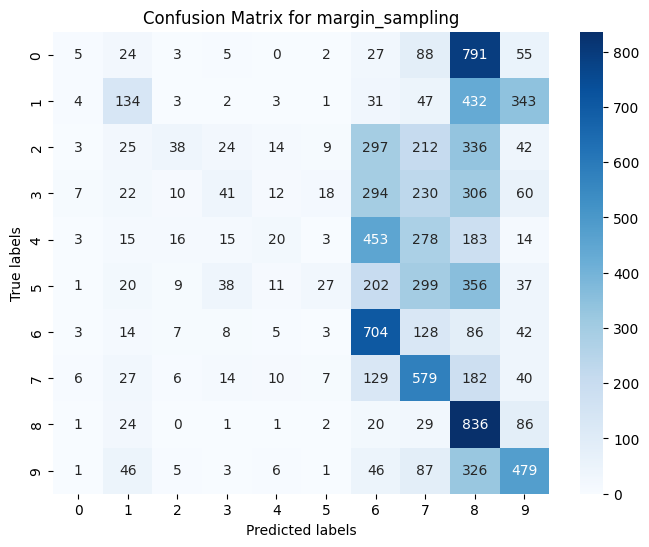

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for margin_sampling')
plt.show()

# ***entropy_sampling:***

prepare data

In [24]:
#labeled data
initial_idx = slice(400)
X_initial_3 = X_train[initial_idx]
y_initial_3 = y_train[initial_idx]


#unlabeled data
X_pool_3 = np.delete(X_train, initial_idx, axis=0)
y_pool_3 = np.delete(y_train, initial_idx, axis=0)

In [25]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = entropy_sampling,
    X_training=X_initial_3,
    y_training=y_initial_3
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.2627 - loss: 3.0502


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - accuracy: 0.5761 - loss: 1.5385
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.7427 - loss: 0.8933
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.8403 - loss: 0.5429
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - accuracy: 0.9010 - loss: 0.3567
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 508ms/step - accuracy: 0.9061 - loss: 0.3089
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step - accuracy: 0.9397 - loss: 0.2161
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - accuracy: 0.9534 - loss: 0.1633
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 576ms/step - accuracy: 0.9771 - loss: 0.1128
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step - accuracy: 0.9800 - loss: 0.0942
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 0.9778 - loss: 0.0952
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Query 10, Accuracy: 0.2858


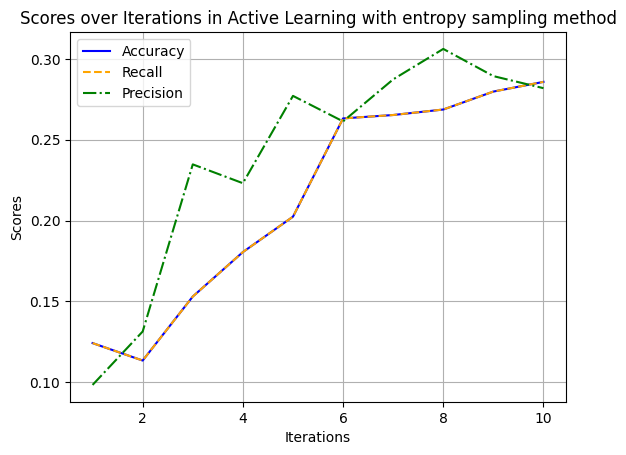

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = []
recalls  = []
precisions = []
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_3)
    X_query, y_query = X_pool_3[query_idx], y_pool_3[query_idx]


    learner.teach(X=X_query, y=y_query)

    X_pool_3 = np.delete(X_pool_3, query_idx, axis=0)
    y_pool_3 = np.delete(y_pool_3, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)

    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")

plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with entropy sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [27]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.2858


In [28]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.2818962132595956
Recall: 0.2858
F1-score: 0.21422950564555818


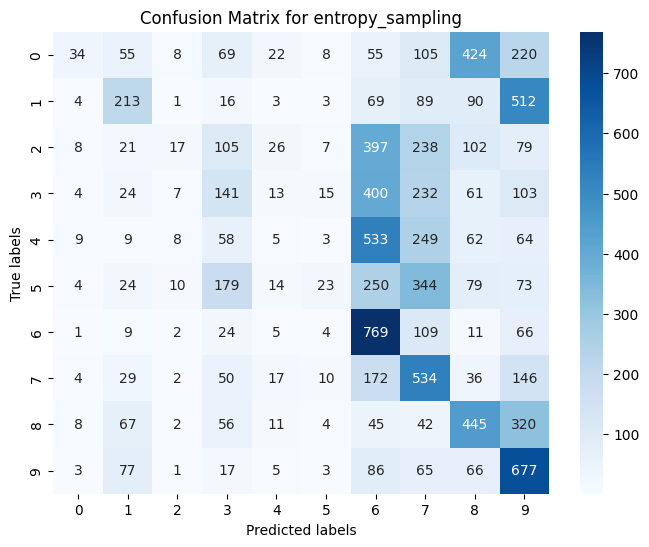

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for entropy_sampling')
plt.show()

# ***uncertainty_sampling (Least Confidence Sampling):***

prepare data

In [30]:
#labeled data
initial_idx = slice(400)
X_initial_4 = X_train[initial_idx]
y_initial_4 = y_train[initial_idx]


#unlabeled data
X_pool_4 = np.delete(X_train, initial_idx, axis=0)
y_pool_4 = np.delete(y_train, initial_idx, axis=0)

In [31]:
def least_confidence_sampling(classifier, X_pool):
    n_instances = 1000
    uncertainties = classifier.predict_proba(X_pool).max(axis=1)
    query_idx = np.argsort(uncertainties)[:n_instances]  # Sort uncertainties and select indices of least confident instances
    return query_idx

In [32]:
from modAL.disagreement import vote_entropy_sampling

learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = uncertainty_sampling,
    X_training=X_initial_4,
    y_training=y_initial_4
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.2386 - loss: 3.2972


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.6160 - loss: 1.2551
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.7120 - loss: 0.8839
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - accuracy: 0.8049 - loss: 0.5307
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 573ms/step - accuracy: 0.8793 - loss: 0.3448
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - accuracy: 0.9176 - loss: 0.2335
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.9448 - loss: 0.1884
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.9470 - loss: 0.1432
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.9515 - loss: 0.1537
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - accuracy: 0.9585 - loss: 0.1095
1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
13/13

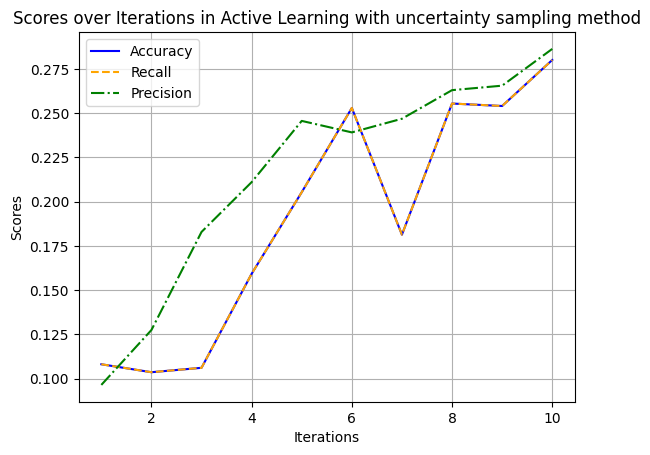

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = []
recalls  = []
precisions = []
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_4)
    X_query, y_query = X_pool_4[query_idx], y_pool_4[query_idx]


    learner.teach(X=X_query, y=y_query)

    X_pool_4 = np.delete(X_pool_4, query_idx, axis=0)
    y_pool_4 = np.delete(y_pool_4, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)

    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")

plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with uncertainty sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [34]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.28


In [35]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.2862483609195295
Recall: 0.28
F1-score: 0.2034737717439316


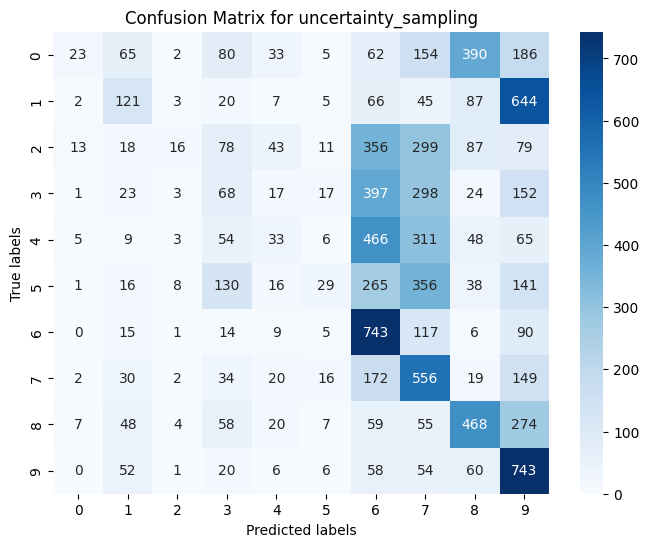

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for uncertainty_sampling')
plt.show()

# ***passive learning: ***

In [37]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [39]:
# Train the model
history = model.fit(x_train, y_train, epochs=50)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.4023 - loss: 1.9519
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6512 - loss: 0.9968
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6991 - loss: 0.8506
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7402 - loss: 0.7372
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7602 - loss: 0.6772
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7789 - loss: 0.6320
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7999 - loss: 0.5695
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8186 - loss: 0.5143
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8340 - loss: 0.4735
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8445 - loss: 0.4440
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8514 - loss: 0.4160
Epoch 12/50
1563/1563 ━━━

In [40]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


313/313 - 2s - 7ms/step - accuracy: 0.8048 - loss: 0.8821
Test accuracy: 0.8047999739646912


In [41]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.8101688087491878
Recall: 0.8048
F1-score: 0.8056544824723215


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 800x800 with 0 Axes>

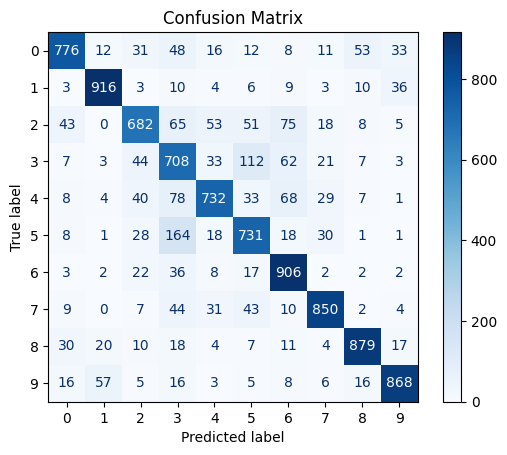

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
